New simulations after choosing $\zeta$ to match old 71cm data and updating VBR numbers including the B state

Trying out force profiles computed in Mathematica from rate equations, then using interpolation between them in Julia

Update here is to use the actual measured sideband spectrum, rather than an analytical approximation (which is more perfect than the actual sidebands)

# Set up constants, global functions etc

In [1]:
# using Revise, BeamPropagation, Distributions, StatsBase, StaticArrays, PhysicalConstants.CODATA2018, Plots, BenchmarkTools
using BeamPropagation, Distributions, PhysicalConstants.CODATA2018, StatsBase, StaticArrays, Plots, BenchmarkTools, DelimitedFiles, StructArrays, Interpolations

In [2]:
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Δv = ħ * k / m
const Γ = 1/(25e-9)
;

In [3]:
vz_μ = @with_unit 125 "m/s"
vz_σ = @with_unit 25 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 25 "m/s" #approximately 4 K
exit_radius = @with_unit 4 "mm"
;

In [4]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [5]:
@inline function random_unit3Dvector()
    θ = rand(Uniform(0, 2π))
    z = rand(Uniform(-1, 1))
    return @SVector [sqrt(1-z^2)*cos(θ), sqrt(1-z^2)*sin(θ), z]
end
;

## Scanning $\zeta$ for consistency with 71cm beamline results

In [6]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 71  "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [7]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len) || (r[3] < -0.05)

@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        v = particles.v[i]
        s.vzs[idx] = v[3]
    end
    return nothing
end
;

In [8]:
@inline function transverse_on(z)
    if 0.175 < z < 0.20     # 1st transverse region 17.5 - 20 cm after cell
        return true
    elseif 0.45 < z < 0.50  # 2nd transverse region 45 - 50 cm after cell
        return true
    elseif 0.56 < z < 0.61  # 2nd transverse region 56 - 61 cm after cell
        return true
    else
        return false
    end
end
;

In [9]:
#updated VBRs 9/28/21
VBRs = Weights([
    0.946961,     # to 000
    0.046456,     # 100
    2.585e-3,     # 0200
    1.708e-3,     # 200
    6.38e-4,     # 0220
    8.16e-4,     # 0110
    3.58e-4,     # 0110, N=2
    1.95e-4,     # 1200
    6.5e-5,     # 300
    4.9e-5,     # 1220
    6.0e-5,     # 110 N=1
    2.4e-5,     # 110, N=2
    2.8e-5,     # 030 N=1
    5.7e-5      # other statess
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    false,  # 110, N=2
    false,  # 030 N=1
    false   # other states
]

transverse = [
    false,  # to 000
    false,   # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 0110, N=2
    false,  # 1200
    false,   # 300
    true,   # 1220
    true,   # 110
    false,   # 110, N=2
    false,  # 030 N=1
    false   # other states
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    566,
    623,
    651,
    595,
    646,
    566,
    648,
    600,
    600
]

;

Now import force profiles and set up the interpolation

In [10]:
io = open("ForceCurves\\Rsc270MHzReal.txt","r")
Rsc300 = readdlm(io,Float64)
close(io)

In [11]:
Iaxis = Rsc300[1:501,2];
vaxis = Rsc300[1:501:end,1];
Rscarray = zeros(length(vaxis),length(Iaxis))
for i in 1:length(vaxis)
    Rscarray[i,:] = Rsc300[501*(i-1).+(1:501),3] 
end
Rsc_interp = LinearInterpolation((vaxis, Iaxis), Rscarray)
;

In [12]:
@inline function beamwaist(z, p)
    
    waist = (z*(p.ddet-p.dcell)/(detect_zloc)+p.dcell)/2
    if waist > 0
        return waist
    else
        return p.dcell
    end
    #guards against possibility of getting 0 waist (and hence a NaN in the intensity) when at very negative z positions
    
end
;

In [13]:
@inline function velocity_vector(r, v, Δvphot, p)
    
    focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
    z = r[3] + focus_offset
    
    squared_length = r[1]^2 + r[2]^2 + z^2
    
    x_comp = r[1] / squared_length
    y_comp = r[2] / squared_length
    z_comp = z / squared_length
    
    return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
end

;

In [14]:
# the interesting physics (scattering rate vs. position, velocity etc) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
    vmin = -100.
    vmax = 250.
    if vmin < v[3]-p.voff < vmax
        waist = beamwaist(r[3],p)
        I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
        Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
        if isnan(Ir)
            Ir = 0
        end
        Rsc = p.ζ*p.Rsc_interp(v[3]-p.voff,Ir)
    else
        Rsc = 0.
    end
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [15]:
ddet = 0.025 #1/e^2 diameter of beam in detection
dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
power = 1200. #mW
ζ = 0.15
voff = 0. #offset of bottom edge of sidebands from zero
p = @params (ddet, dcell, power, ζ, voff, Rsc_interp)
rs = 0:0.01:0.81
Rscatts0 = zeros(size(rs,1))
Rscatts1 = zeros(size(rs,1))
Rscatts2 = zeros(size(rs,1))
Rscatts3 = zeros(size(rs,1))
Rscatts4 = zeros(size(rs,1))
Rscatts5 = zeros(size(rs,1))
for i in 1:length(rs)
    Rscatts0[i] = Rscatt(SVector(0.,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts1[i] = Rscatt(SVector(1e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts2[i] = Rscatt(SVector(2e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts3[i] = Rscatt(SVector(3e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts4[i] = Rscatt(SVector(4e-3,0.,rs[i]),SVector(0.,0.,100.),p)
    Rscatts5[i] = Rscatt(SVector(5e-3,0.,rs[i]),SVector(0.,0.,100.),p)
end

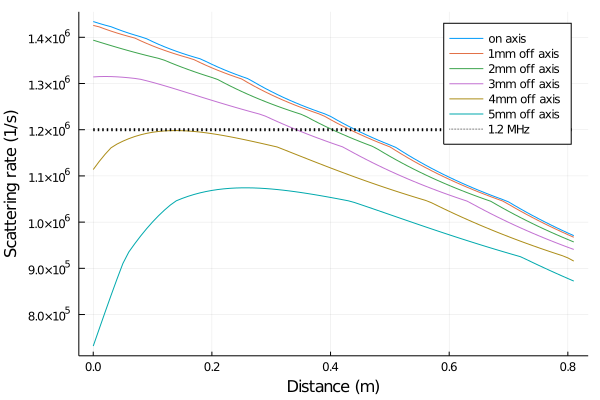

In [19]:
plot(rs,Rscatts0, label = "on axis")
plot!(rs,Rscatts1, label = "1mm off axis")
plot!(rs,Rscatts2, label = "2mm off axis")
plot!(rs,Rscatts3, label = "3mm off axis")
plot!(rs,Rscatts4, label = "4mm off axis")
plot!(rs,Rscatts5, label = "5mm off axis")
plot!([0.,0.81],[1.2e6,1.2e6],lw = 3, linestyle = :dot, color = "black", label = "1.2 MHz")
xlabel!("Distance (m)")
ylabel!("Scattering rate (1/s)")

In [20]:
vs = -40:1:200
Rscatts = zeros(size(vs,1))
for i in 1:length(vs)
    Rscatts[i] = Rscatt(SVector(0.,0.,0.5),SVector(0.,0.,vs[i]),p)
end

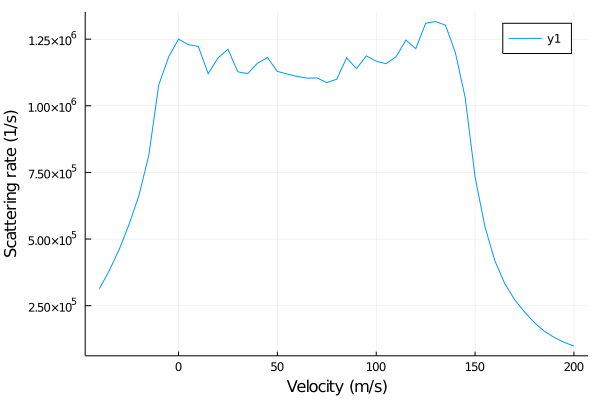

In [21]:
plot(vs,Rscatts)
xlabel!("Velocity (m/s)")
ylabel!("Scattering rate (1/s)")

In [22]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
#         s.total_time[idx] += particles.dt[i]
        
        if ~p.noslow && p.addressed[state] && (~p.transverse[state] || transverse_on(r[3]))
            dt′ = update_Rsc(r,v,p)
            state′ = sample(1:14,p.VBRs)
            particles.dt[i] = dt′
            particles.use_adaptive[i] = false
            v′ = velocity_vector(r, v, Δv, p)
            v′ += Δv .* random_unit3Dvector()
            s.photons[idx] += 1
        else
            state′ = state
            v′ = v
            particles.use_adaptive[i] = true
        end
        s.states[idx] = state′
        s.vzs[idx] = v′[3]
        particles.v[i] = v′
        
        s.detectable[idx] |= is_detectable(r) #updating "or" operator (either s.detectable[idx] is true, or updates s.detectable[idx] to is_detectable(r))
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end

;

In [38]:
#run for N=iters iterations
iters = 5

n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true

vzs_unp_all = Array{Float64}(undef, 0)
vzs_slowed_all = Array{Float64}(undef, 0)
for i in 1:iters
    
    dt0 = 1e-5
    photons = zeros(Int64, n)
    detectable = zeros(Bool, n)
    states = ones(Int64, n)
    vzs = zeros(Float64, n)
    ddet = 0.025 #1/e^2 diameter of beam in detection
    dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
    power = 1200 #mW
    ζ = 0.21
    voff = 0. #offset of bottom edge of sidebands from zero

    noslow = false
    p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp)
    s = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)
    
    bright = [addressed[final_state] for final_state in s.states];

    append!(vzs_slowed_all, s.vzs[s.detectable .& bright])
    
    noslow = true
    p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp)
    s0 = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)
    
    append!(vzs_unp_all, s0.vzs[s0.detectable])
    
end

 10.434133 seconds (15.00 M allocations: 5.839 GiB, 21.84% gc time)
  3.109990 seconds (15.00 M allocations: 5.839 GiB, 29.99% gc time)
  6.836060 seconds (15.00 M allocations: 5.839 GiB, 29.28% gc time)
  3.180246 seconds (15.00 M allocations: 5.839 GiB, 30.42% gc time)
  6.886789 seconds (15.00 M allocations: 5.839 GiB, 28.29% gc time)
  4.542564 seconds (15.00 M allocations: 5.839 GiB, 46.25% gc time)
  7.527191 seconds (15.00 M allocations: 5.839 GiB, 25.76% gc time)
  3.540603 seconds (15.00 M allocations: 5.839 GiB, 37.12% gc time)
  8.674125 seconds (15.00 M allocations: 5.839 GiB, 23.77% gc time)
  3.051633 seconds (15.00 M allocations: 5.839 GiB, 27.69% gc time)


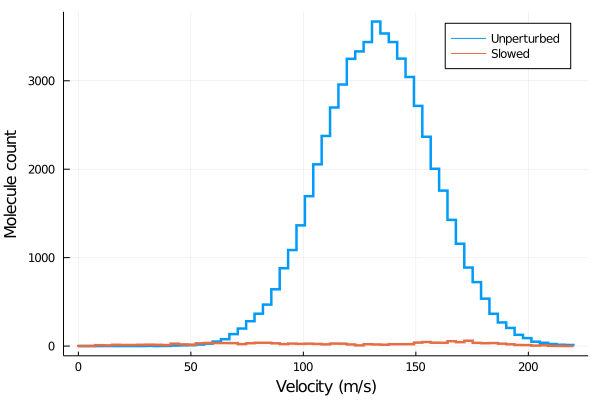

In [39]:
pbins = range(0, stop=220, length=60)
plot(vzs_unp_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Unperturbed")
plot!(vzs_slowed_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Slowed")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [48]:
#run for N=iters iterations
iters = 1

n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true

vzs_unp_all = Array{Float64}(undef, 0)
vzs_slowed_all = Array{Float64}(undef, 0)
for i in 1:iters
    
    dt0 = 1e-5
    photons = zeros(Int64, n)
    detectable = zeros(Bool, n)
    states = ones(Int64, n)
    vzs = zeros(Float64, n)
    ddet = 0.025 #1/e^2 diameter of beam in detection
    dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
    power = 1200 #mW
    ζ = 0.21
    voff = 70. #offset of bottom edge of sidebands from zero

    noslow = false
    p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp)
    s = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)
    
    bright = [addressed[final_state] for final_state in s.states];

    append!(vzs_slowed_all, s.vzs[s.detectable .& bright])
    
    noslow = true
    p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp)
    s0 = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)
    
    append!(vzs_unp_all, s0.vzs[s0.detectable])
    
end

  6.013435 seconds (15.00 M allocations: 5.839 GiB, 20.50% gc time)
  4.303891 seconds (15.00 M allocations: 5.839 GiB, 48.13% gc time)


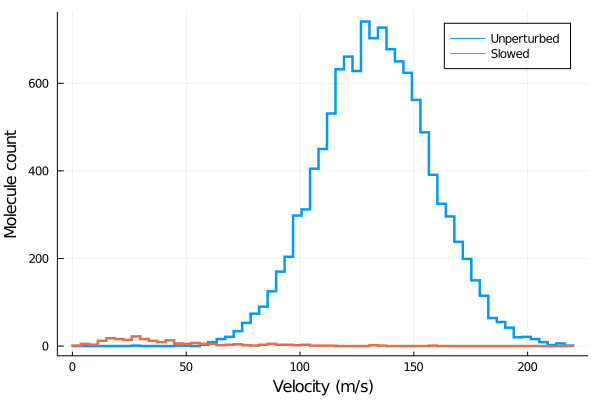

In [49]:
pbins = range(0, stop=220, length=60)
plot(vzs_unp_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Unperturbed")
plot!(vzs_slowed_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Slowed")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [43]:
v_low_cut = 10
v_low = 0 .< vzs_slowed_all .< v_low_cut
v_20 = 17.5 .< vzs_slowed_all .< 22.5
v_40 = 37.5 .< vzs_slowed_all .< 42.5
println("Number detected in unperturbed beam: ", length(vzs_unp_all))
println("Number detected (i.e. in bright states) in slowed beam: ", length(vzs_slowed_all))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(vzs_slowed_all[v_low]))
slow_frac = length(vzs_slowed_all[v_low])/length(vzs_unp_all)
slow_frac_20 = length(vzs_slowed_all[v_20])/length(vzs_unp_all)
slow_frac_40 = length(vzs_slowed_all[v_40])/length(vzs_unp_all)
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number below ", v_low_cut, " from 2e7 initial: ", slow_frac*2e7)
println("Fraction of unperturbed between 17.5 and 22.5 m/s: ", slow_frac_20)
println("Number between 17.5 and 22.5 m/s from 2e7 initial: ", slow_frac_20*2e7)
println("Fraction of unperturbed between 37.5 and 42.5 m/s: ", slow_frac_40)
println("Number between 37.5 and 42.5 m/s from 2e7 initial: ", slow_frac_40*2e7)

Number detected in unperturbed beam: 12469
Number detected (i.e. in bright states) in slowed beam: 822
Number detected below 10 m/s in slowed beam: 17
Fraction of unperturbed below 10 m/s: 0.0013633811853396424
Number below 10 from 2e7 initial: 27267.62370679285
Fraction of unperturbed between 17.5 and 22.5 m/s: 0.00521292806159275
Number between 17.5 and 22.5 m/s from 2e7 initial: 104258.56123185501
Fraction of unperturbed between 37.5 and 42.5 m/s: 0.008019889325527307
Number between 37.5 and 42.5 m/s from 2e7 initial: 160397.78651054614


## 81cm beamline with N=3 velocity compression

In [50]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 81  "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [51]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len) || (r[3] < -0.05)

@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        v = particles.v[i]
        s.vzs[idx] = v[3]
    end
    return nothing
end
;

In [53]:
@inline function transverse_on(z)
    if (0.756 - 0.008) < z < (0.756 + 0.008)     #N=3 repumping
        return true
    else
        return false
    end
end
;

In [54]:
#updated VBRs 9/28/21
VBRs = Weights([
    0.946961,     # to 000
    0.046456,     # 100
    2.585e-3,     # 0200
    1.708e-3,     # 200
    6.38e-4,     # 0220
    8.16e-4,     # 0110
    3.58e-4,     # 0110, N=2
    1.95e-4,     # 1200
    6.5e-5,     # 300
    4.9e-5,     # 1220
    6.0e-5,     # 110 N=1
    2.4e-5,     # 110, N=2
    2.8e-5,     # 030 N=1
    5.7e-5      # other statess
])

addressed = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    true,   # 1220
    true,   # 110
    false,  # 110, N=2
    false,  # 030 N=1
    false,   # other states
    false #N=3 "dark state" for shelving
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    566,
    623,
    651,
    595,
    646,
    566,
    648,
    600,
    600
]

;

Now import force profiles and set up the interpolation

In [55]:
io = open("ForceCurves\\Rsc270MHzReal.txt","r")
Rsc300 = readdlm(io,Float64)
close(io)

In [56]:
Iaxis = Rsc300[1:501,2];
vaxis = Rsc300[1:501:end,1];
Rscarray = zeros(length(vaxis),length(Iaxis))
for i in 1:length(vaxis)
    Rscarray[i,:] = Rsc300[501*(i-1).+(1:501),3] 
end
Rsc_interp = LinearInterpolation((vaxis, Iaxis), Rscarray)
;

In [57]:
@inline function beamwaist(z, p)
    
    waist = (z*(p.ddet-p.dcell)/(detect_zloc)+p.dcell)/2
    if waist > 0
        return waist
    else
        return p.dcell
    end
    #guards against possibility of getting 0 waist (and hence a NaN in the intensity) when at very negative z positions
    
end
;

In [58]:
@inline function velocity_vector(r, v, Δvphot, p)
    
    focus_offset = p.dcell/(p.ddet-p.dcell)*detect_zloc
    z = r[3] + focus_offset
    
    squared_length = r[1]^2 + r[2]^2 + z^2
    
    x_comp = r[1] / squared_length
    y_comp = r[2] / squared_length
    z_comp = z / squared_length
    
    return @SVector [v[1] - Δvphot * x_comp, v[2] - Δvphot * y_comp, v[3] - Δvphot * z_comp]
    
end

;

In [59]:
# the interesting physics (scattering rate vs. position, velocity etc) is contained in this function
# scattering rate expression taken from effective two-level model worked out in Mathematica notebook, plus an overall reduction factor ζ in the scattering rate
@inline function Rscatt(r,v,p)
    vmin = -100.
    vmax = 250.
    if vmin < v[3]-p.voff < vmax
        waist = beamwaist(r[3],p)
        I0 = 2*p.power/(pi*waist^2)*1e-4 #mW/cm^2
        Ir = I0*exp(-2*(r[1]^2+r[2]^2)/(waist^2))
        if isnan(Ir)
            Ir = 0
        end
        Rsc = p.ζ*p.Rsc_interp(v[3]-p.voff,Ir)
    else
        Rsc = 0.
    end
    return Rsc
end

@inline function update_Rsc(r, v, p)
    Rsc = Rscatt(r,v,p)
    if iszero(Rsc)
        dt = p.dt0
    else
        dt = 1/Rsc
    end
    return dt
end

;

In [60]:
@inline function Rscatt_N3(v,p)
    ΔN3 = p.δN3 - k*v[3]
    Rsc = Γ/(4*5)*p.satN3/(1+p.satN3+4*ΔN3^2/Γ^2)
    return Rsc
end

@inline function update_N3(dt,v,p)
    Rsc = Rscatt_N3(v,p)
    prob = dt*Rsc
    rphot = rand()
    rhonl = rand()
    if (rphot < prob) && (rhonl < 0.3) #probabilistically determine if photon is scattered, then if decay is to N=3 (0.3 to N=3, 0.7 back to N=1 from honl-london factor)
        return true
    else
        return false
    end
end
;

In [61]:
δN3 = 2*pi*80*10^6
satN3 = 0.001
p = @params (δN3,satN3)
vs = 0:1:100
Rscatts0 = zeros(size(vs,1))
for i in 1:length(vs)
    Rscatts0[i] = Rscatt_N3(SVector(0.,0.,vs[i]),p)
end

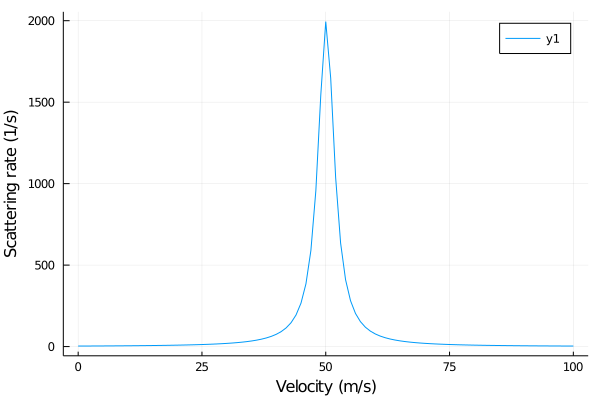

In [62]:
plot(vs,Rscatts0)
xlabel!("Velocity (m/s)")
ylabel!("Scattering rate (1/s)")

In [63]:
@inline function update(particles, p, s, dt)
    for i in 1:size(particles, 1)
        idx   = particles.idx[i]
        state = s.states[idx]
        
        r = particles.r[i]
        v = particles.v[i]
        
#         s.total_time[idx] += particles.dt[i]
        
        if ~p.noslow && p.addressed[state]
            dt′ = update_Rsc(r,v,p)
            state′ = sample(1:14,p.VBRs)
            particles.dt[i] = dt′
            particles.use_adaptive[i] = false
            v′ = velocity_vector(r, v, Δv, p)
            v′ += Δv .* random_unit3Dvector()
            s.photons[idx] += 1
            
            if state′ == 1 && update_N3(dt′,v′,p) #check if pumped into N=3
                state′ = 15
            end
        else
            if transverse_on(r[3]) && state == 15 #check if pumped back from N=3
                state′ = 1
            else
                state′ = state
            end
            v′ = v
            particles.use_adaptive[i] = true
        end
        s.states[idx] = state′
        s.vzs[idx] = v′[3]
        particles.v[i] = v′
        
        s.detectable[idx] |= is_detectable(r) #updating "or" operator (either s.detectable[idx] is true, or updates s.detectable[idx] to is_detectable(r))
    end
    return nothing
end

@inline function f(idx, r, v, p)
    
    return SVector(0., 0., 0.)
    
end

;

In [89]:
#run for N=iters iterations
iters = 5

n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true

vzs_unp_all = Array{Float64}(undef, 0)
vzs_slowed_all = Array{Float64}(undef, 0)
for i in 1:iters
    
    dt0 = 1e-5
    photons = zeros(Int64, n)
    detectable = zeros(Bool, n)
    states = ones(Int64, n)
    vzs = zeros(Float64, n)
    ddet = 0.025 #1/e^2 diameter of beam in detection
    dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
    power = 1200 #mW
    ζ = 0.15
    voff = 0. #offset of bottom edge of sidebands from zero
    δN3 = 2*pi*60*10^6
#     satN3 = 0.015
    satN3 = 0.

    noslow = false
    p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp, δN3, satN3)
    s = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)
    
    bright = [addressed[final_state] for final_state in s.states];

    append!(vzs_slowed_all, s.vzs[s.detectable .& bright])
    
    noslow = true
    p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp, δN3, satN3)
    s0 = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)
    
    append!(vzs_unp_all, s0.vzs[s0.detectable])
    
end

  7.320429 seconds (15.00 M allocations: 5.839 GiB, 27.14% gc time)
  4.306501 seconds (15.00 M allocations: 5.839 GiB, 49.45% gc time)
  7.649135 seconds (15.00 M allocations: 5.839 GiB, 25.13% gc time)
  4.677738 seconds (15.00 M allocations: 5.839 GiB, 44.47% gc time)
  9.568295 seconds (15.00 M allocations: 5.839 GiB, 22.88% gc time)
  4.174027 seconds (15.00 M allocations: 5.839 GiB, 48.48% gc time)
  7.636574 seconds (15.00 M allocations: 5.839 GiB, 26.81% gc time)
  3.002525 seconds (15.00 M allocations: 5.839 GiB, 27.75% gc time)
  7.629970 seconds (15.00 M allocations: 5.839 GiB, 25.33% gc time)
  4.315077 seconds (15.00 M allocations: 5.839 GiB, 47.59% gc time)


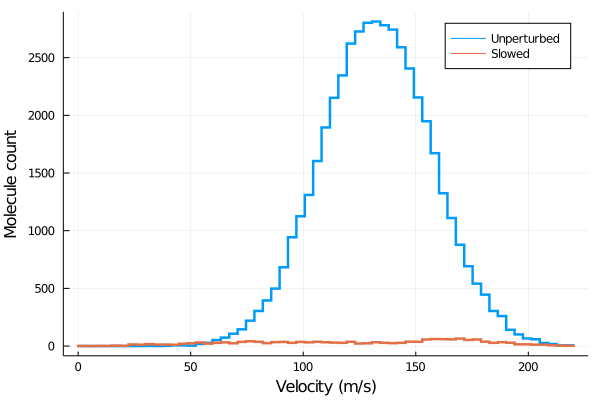

In [90]:
pbins = range(0, stop=220, length=60)
plot(vzs_unp_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Unperturbed")
plot!(vzs_slowed_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Slowed")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [91]:
v_low_cut = 10
v_low = 0 .< vzs_slowed_all .< v_low_cut
v_20 = 17.5 .< vzs_slowed_all .< 22.5
v_40 = 37.5 .< vzs_slowed_all .< 42.5
println("Number detected in unperturbed beam: ", length(vzs_unp_all))
println("Number detected (i.e. in bright states) in slowed beam: ", length(vzs_slowed_all))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(vzs_slowed_all[v_low]))
slow_frac = length(vzs_slowed_all[v_low])/length(vzs_unp_all)
slow_frac_20 = length(vzs_slowed_all[v_20])/length(vzs_unp_all)
slow_frac_40 = length(vzs_slowed_all[v_40])/length(vzs_unp_all)
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number below ", v_low_cut, " from 2e7 initial: ", slow_frac*2e7)
println("Fraction of unperturbed between 17.5 and 22.5 m/s: ", slow_frac_20)
println("Number between 17.5 and 22.5 m/s from 2e7 initial: ", slow_frac_20*2e7)
println("Fraction of unperturbed between 37.5 and 42.5 m/s: ", slow_frac_40)
println("Number between 37.5 and 42.5 m/s from 2e7 initial: ", slow_frac_40*2e7)

Number detected in unperturbed beam: 47168
Number detected (i.e. in bright states) in slowed beam: 1584
Number detected below 10 m/s in slowed beam: 2
Fraction of unperturbed below 10 m/s: 4.240162822252374e-5
Number below 10 from 2e7 initial: 848.0325644504749
Fraction of unperturbed between 17.5 and 22.5 m/s: 8.480325644504748e-5
Number between 17.5 and 22.5 m/s from 2e7 initial: 1696.0651289009497
Fraction of unperturbed between 37.5 and 42.5 m/s: 0.0003604138398914518
Number between 37.5 and 42.5 m/s from 2e7 initial: 7208.276797829037


In [86]:
#run for N=iters iterations
iters = 5

n = Int64(15e6)
save_every = 150
delete_every = 50
dt = 1e-7
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-10
max_steps = Int64(1e5)
alg = "rkf12"
use_adaptive = true

vzs_unp_all = Array{Float64}(undef, 0)
vzs_slowed_all = Array{Float64}(undef, 0)
for i in 1:iters
    
    dt0 = 1e-5
    photons = zeros(Int64, n)
    detectable = zeros(Bool, n)
    states = ones(Int64, n)
    vzs = zeros(Float64, n)
    ddet = 0.025 #1/e^2 diameter of beam in detection
    dcell = 2*exit_radius #1/e^2 diameter of beam at the cell
    power = 1200 #mW
    ζ = 0.15
    voff = 0. #offset of bottom edge of sidebands from zero
    δN3 = 2*pi*58*10^6
    satN3 = 0.01

    noslow = false
    p = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp, δN3, satN3)
    s = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)
    
    bright = [addressed[final_state] for final_state in s.states];

    append!(vzs_slowed_all, s.vzs[s.detectable .& bright])
    
    noslow = true
    p0 = @params (VBRs, addressed, transverse, λs, dt0, noslow, ddet, dcell, power, ζ, voff, Rsc_interp, δN3, satN3)
    s0 = @params (vzs, photons, detectable, states)
    particles = StructArray{Particle}(undef, n)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p0, s0, dt, use_adaptive, dt_min, dt_max, abstol)
    
    append!(vzs_unp_all, s0.vzs[s0.detectable])
    
end

  6.220381 seconds (15.00 M allocations: 5.839 GiB, 31.16% gc time)
  3.451562 seconds (15.00 M allocations: 5.839 GiB, 38.44% gc time)
  6.110058 seconds (15.00 M allocations: 5.839 GiB, 31.01% gc time)
  4.221290 seconds (15.00 M allocations: 5.839 GiB, 47.10% gc time)
  5.576079 seconds (15.00 M allocations: 5.839 GiB, 21.81% gc time)
  4.213042 seconds (15.00 M allocations: 5.839 GiB, 48.62% gc time)
  5.530835 seconds (15.00 M allocations: 5.839 GiB, 19.61% gc time)
  4.108882 seconds (15.00 M allocations: 5.839 GiB, 48.19% gc time)
  6.122030 seconds (15.00 M allocations: 5.839 GiB, 28.49% gc time)
  4.581547 seconds (15.00 M allocations: 5.839 GiB, 47.09% gc time)


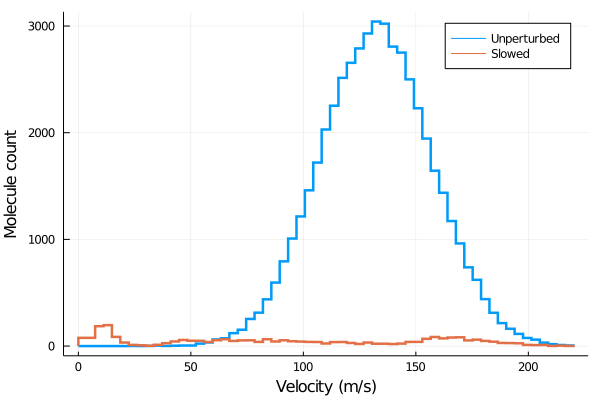

In [87]:
pbins = range(0, stop=220, length=60)
plot(vzs_unp_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Unperturbed")
plot!(vzs_slowed_all, lw=2.5, seriestype=:stephist, bins=pbins, label="Slowed")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

In [88]:
v_low_cut = 10
v_low = 0 .< vzs_slowed_all .< v_low_cut
v_20 = 17.5 .< vzs_slowed_all .< 22.5
v_40 = 37.5 .< vzs_slowed_all .< 42.5
println("Number detected in unperturbed beam: ", length(vzs_unp_all))
println("Number detected (i.e. in bright states) in slowed beam: ", length(vzs_slowed_all))
println("Number detected below ", v_low_cut, " m/s in slowed beam: ", length(vzs_slowed_all[v_low]))
slow_frac = length(vzs_slowed_all[v_low])/length(vzs_unp_all)
slow_frac_20 = length(vzs_slowed_all[v_20])/length(vzs_unp_all)
slow_frac_40 = length(vzs_slowed_all[v_40])/length(vzs_unp_all)
println("Fraction of unperturbed below ", v_low_cut, " m/s: ", slow_frac)
println("Number below ", v_low_cut, " from 2e7 initial: ", slow_frac*2e7)
println("Fraction of unperturbed between 17.5 and 22.5 m/s: ", slow_frac_20)
println("Number between 17.5 and 22.5 m/s from 2e7 initial: ", slow_frac_20*2e7)
println("Fraction of unperturbed between 37.5 and 42.5 m/s: ", slow_frac_40)
println("Number between 37.5 and 42.5 m/s from 2e7 initial: ", slow_frac_40*2e7)

Number detected in unperturbed beam: 49780
Number detected (i.e. in bright states) in slowed beam: 2703
Number detected below 10 m/s in slowed beam: 282
Fraction of unperturbed below 10 m/s: 0.005664925672961028
Number below 10 from 2e7 initial: 113298.51345922057
Fraction of unperturbed between 17.5 and 22.5 m/s: 0.001064684612294094
Number between 17.5 and 22.5 m/s from 2e7 initial: 21293.69224588188
Fraction of unperturbed between 37.5 and 42.5 m/s: 0.0008236239453595822
Number between 37.5 and 42.5 m/s from 2e7 initial: 16472.478907191642
